In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from fastai import *
from fastai.tabular import *
from fastai.callbacks import *
from fastai.text import *
from fastai.data_block import *
from fastai.metrics import *
from sklearn.model_selection import StratifiedKFold
import pickle
from fastprogress import master_bar, progress_bar
from IPython.display import FileLink
from sklearn.decomposition import PCA
import time
from swallows.training import *

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [29]:
model_name = 'tab-v4-tuning-3-stage-4-hyper'

In [5]:
path=Path('data')

In [6]:
df_raw = pd.read_parquet(path/'processed/training_stage_4.parquet')
df_raw_test = pd.read_parquet(path/'processed/public_test_features_stage_4.parquet')

In [7]:
df_train = df_raw
df_test = df_raw_test

In [8]:
df_root_cause_counts = pd.DataFrame(df_raw.groupby(['root_cause']).size().sort_values(ascending=False), columns=['count'])

In [9]:
min_size = 500
large_cats = df_root_cause_counts[df_root_cause_counts["count"] > min_size]
total_count = int(df_root_cause_counts.sum())
total_big_enough_covered =float(large_cats.sum()*100/df_root_cause_counts.sum())
print(f'Total cats: {len(df_root_cause_counts)} with {total_count} items')
print(f'cats w/ >{min_size} items: {len(large_cats)} with {total_big_enough_covered:.2f}% coverage')

Total cats: 960 with 1156151 items
cats w/ >500 items: 81 with 97.40% coverage


# Simple tabular NN

In [10]:
exclude_from_cats = [
    'ID', 
    'assigned_date',
    'create_date',
    'details',
    'short_description',
    'amazon_domains',
    'root_cause',
    'create_to_assigned_lag'
    'create_to_assigned_lag_log',
    'assigned_date_Elapsed'
    'create_date_Elapsed',
]

cat_names = [c for c in df_raw.columns if c not in exclude_from_cats]
cont_names = [] #['create_to_assigned_lag_log']
dep_var = 'root_cause'
procs = [FillMissing, Categorify, Normalize]

In [11]:
test = TabularList.from_df(df_test[cat_names + cont_names], path=path, cat_names=cat_names, cont_names=cont_names)

In [12]:
train_data = df_train[df_train['root_cause'].isin(large_cats.reset_index()['root_cause'])]
train_data = train_data[cat_names + cont_names + [dep_var]]

In [13]:
# splits_idxs = [s for s in gen_splits(10, train_data, 'root_cause')]
# pickle.dump(splits_idxs, open(path/f'{model_name}_cv_splits-10.pkl', "wb"))

In [14]:
splits_idxs = pickle.load(open(path/f'{model_name}_cv_splits-10.pkl', "rb"))
split = splits_idxs[7]

In [15]:
data = (TabularList.from_df(train_data, 
                            path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idxs(split[0], split[1])
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch(bs=1024))

In [61]:
def run_loop(p,lr,epochs):
    print(f'Training: epochs={epochs} | lr={lr} | p={p}')
    learn = tabular_learner(data, layers=[727,353], ps=p, emb_drop=p, metrics=accuracy)
    learn.fit_one_cycle(epochs, lr); learn.recorder.plot_losses()
    learn.save(f'{model_name}-{epochs}-{lr}-{p}-fitted')
    del learn
    gc.collect()
    torch.cuda.empty_cache()    

epochs=30 | lr=0.001 | p=0.25


epoch,train_loss,valid_loss,accuracy,time
0,1.821017,1.710087,0.502980,01:35
1,1.559209,1.483163,0.529883,01:35
2,1.491542,1.419325,0.542069,01:35
3,1.446296,1.396555,0.546847,01:35
4,1.429814,1.380040,0.551288,01:35
5,1.415097,1.363464,0.554823,01:36
6,1.397942,1.350669,0.556538,01:35
7,1.383627,1.336484,0.562941,01:36
8,1.366321,1.326106,0.564895,01:36
9,1.353991,1.319124,0.567320,01:36


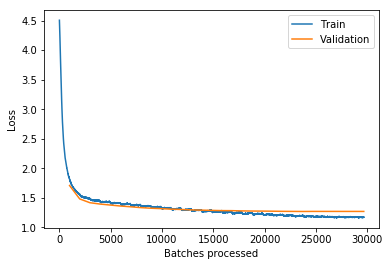

In [37]:
run_loop(p=0.25, lr=1e-3, epochs=30) # 0.585661

epochs=30 | lr=0.001 | p=0.3


epoch,train_loss,valid_loss,accuracy,time
0,1.866544,1.743375,0.498317,01:34
1,1.584091,1.495827,0.527627,01:34
2,1.503365,1.430377,0.539671,01:35
3,1.470659,1.402935,0.545275,01:35
4,1.445117,1.384755,0.549592,01:35
5,1.442150,1.374004,0.550507,01:35
6,1.413907,1.358669,0.556360,01:36
7,1.406735,1.348109,0.558634,01:35
8,1.391296,1.336113,0.562080,01:36
9,1.376672,1.328662,0.564220,01:35


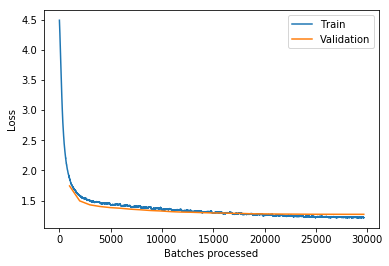

In [38]:
run_loop(p=0.30, lr=1e-3, epochs=30) # 0.583787

epochs=30 | lr=0.001 | p=0.2


epoch,train_loss,valid_loss,accuracy,time
0,1.796352,1.698431,0.506346,01:35
1,1.532726,1.472070,0.531873,01:35
2,1.464327,1.410579,0.544520,01:35
3,1.434177,1.386076,0.551049,01:35
4,1.413286,1.369745,0.554086,01:35
5,1.394206,1.355852,0.559211,01:35
6,1.372798,1.341528,0.561112,01:36
7,1.346049,1.331860,0.563110,01:35
8,1.342278,1.322363,0.567258,01:35
9,1.318130,1.313967,0.569070,01:36


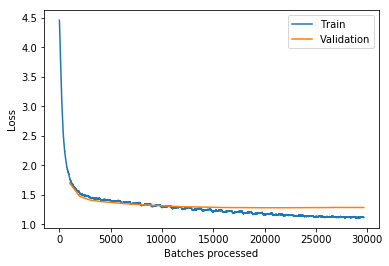

In [39]:
run_loop(p=0.20, lr=1e-3, epochs=30) # 0.586620 <<< best

epochs=30 | lr=0.001 | p=0.35


epoch,train_loss,valid_loss,accuracy,time
0,1.910682,1.772906,0.492979,01:35
1,1.616418,1.511814,0.524012,01:35
2,1.532728,1.442301,0.535425,01:35
3,1.498112,1.413710,0.543401,01:35
4,1.476292,1.394449,0.549423,01:35
5,1.449692,1.381961,0.548100,01:36
6,1.434890,1.370557,0.552923,01:36
7,1.426332,1.360295,0.554237,01:36
8,1.416442,1.348790,0.558349,01:36
9,1.400067,1.338450,0.561378,01:36


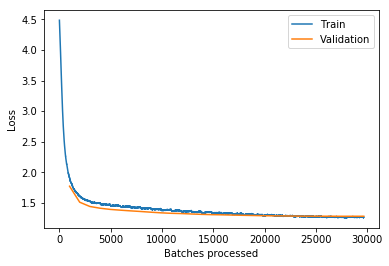

In [40]:
run_loop(p=0.35, lr=1e-3, epochs=30) # 0.578902

epochs=30 | lr=0.001 | p=0.15


epoch,train_loss,valid_loss,accuracy,time
0,1.743562,1.669585,0.509872,01:35
1,1.511607,1.461161,0.534795,01:35
2,1.453546,1.401463,0.545897,01:34
3,1.408183,1.378308,0.552923,01:35
4,1.391580,1.358863,0.557053,01:35
5,1.378557,1.350641,0.559326,01:35
6,1.350996,1.337260,0.561867,01:36
7,1.335265,1.326137,0.564673,01:36
8,1.312804,1.315522,0.569034,01:35
9,1.286942,1.309046,0.571335,01:36


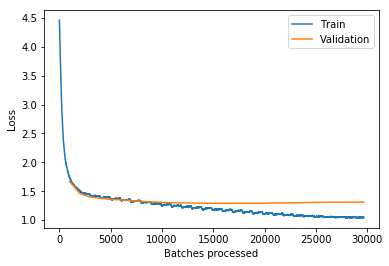

In [41]:
run_loop(p=0.15, lr=1e-3, epochs=30) # 0.585235

epochs=30 | lr=0.001 | p=0.1


epoch,train_loss,valid_loss,accuracy,time
0,1.733700,1.664948,0.512706,01:35
1,1.485490,1.449926,0.538170,01:35
2,1.418390,1.395646,0.547629,01:35
3,1.392780,1.375190,0.551617,01:35
4,1.364568,1.360234,0.556662,01:35
5,1.351879,1.346464,0.560463,01:35
6,1.331283,1.335077,0.564345,01:35
7,1.308924,1.324906,0.567444,01:36
8,1.290001,1.310947,0.571388,01:36
9,1.261700,1.307864,0.574195,01:35


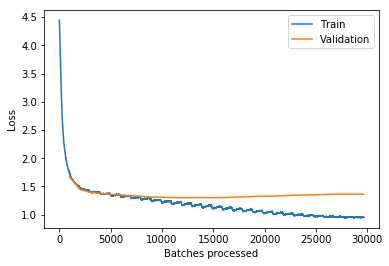

In [42]:
run_loop(p=0.10, lr=1e-3, epochs=30) # 0.583450

epochs=30 | lr=0.001 | p=0.05


epoch,train_loss,valid_loss,accuracy,time
0,1.683249,1.639236,0.515290,01:35
1,1.464892,1.442683,0.539156,01:35
2,1.406468,1.388402,0.550329,01:35
3,1.368994,1.367175,0.555392,01:35
4,1.357438,1.352768,0.558660,01:35
5,1.333043,1.342802,0.561200,01:35
6,1.296996,1.335987,0.566574,01:36
7,1.281625,1.323866,0.568315,01:36
8,1.250735,1.318414,0.571432,01:36
9,1.228624,1.310267,0.574079,01:36


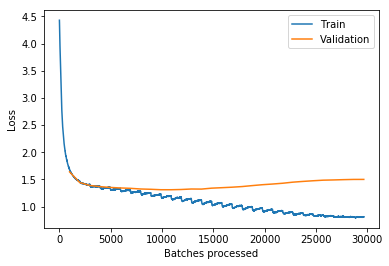

In [43]:
run_loop(p=0.05, lr=1e-3, epochs=30) # 0.573431

Best long cycle:
* run_loop(p=0.20, lr=1e-3, epochs=30) # 0.586620 <<< best

Best short cycles:
* Training: epochs=8 | lr=0.01 | p=0.15 | 0.582783
* Training: epochs=9 | lr=0.01 | p=0.15 | 0.583556

Training: epochs=6 | lr=0.01 | p=0.15


epoch,train_loss,valid_loss,accuracy,time
0,1.526884,1.494915,0.522316,01:35
1,1.455116,1.413000,0.542264,01:35
2,1.390478,1.362474,0.553900,01:35
3,1.329979,1.317194,0.568279,01:35
4,1.268834,1.289953,0.575882,01:35
5,1.225408,1.285891,0.578538,01:35


Training: epochs=6 | lr=0.01 | p=0.2


epoch,train_loss,valid_loss,accuracy,time
0,1.537804,1.482037,0.522804,01:35
1,1.462167,1.424419,0.536562,01:35
2,1.402700,1.370925,0.552585,01:35
3,1.352988,1.324155,0.565721,01:35
4,1.294765,1.296440,0.574212,01:35
5,1.256770,1.290978,0.576264,01:36


Training: epochs=6 | lr=0.01 | p=0.25


epoch,train_loss,valid_loss,accuracy,time
0,1.554501,1.501276,0.518257,01:35
1,1.484343,1.430238,0.538552,01:35
2,1.421572,1.387315,0.548038,01:35
3,1.385867,1.335099,0.561609,01:35
4,1.330874,1.307362,0.569105,01:35
5,1.301366,1.300563,0.572072,01:36


Training: epochs=6 | lr=0.01 | p=0.3


epoch,train_loss,valid_loss,accuracy,time
0,1.571049,1.495420,0.520353,01:35
1,1.492573,1.430497,0.536900,01:35
2,1.443789,1.384776,0.549006,01:35
3,1.400347,1.346017,0.557719,01:36
4,1.350103,1.319579,0.566485,01:35
5,1.331614,1.313103,0.568643,01:36


Training: epochs=6 | lr=0.001 | p=0.15


epoch,train_loss,valid_loss,accuracy,time
0,1.534025,1.484180,0.526508,01:35
1,1.446427,1.406557,0.543437,01:35
2,1.382734,1.352288,0.558216,01:35
3,1.328128,1.315995,0.568270,01:36
4,1.280723,1.295687,0.574674,01:35
5,1.241477,1.292110,0.576424,01:35


Training: epochs=6 | lr=0.001 | p=0.2


epoch,train_loss,valid_loss,accuracy,time
0,1.548650,1.491293,0.522307,01:35
1,1.459486,1.419057,0.540799,01:35
2,1.403303,1.361258,0.554983,01:35
3,1.349504,1.325025,0.566370,01:35
4,1.308098,1.302639,0.571361,01:35
5,1.278433,1.299408,0.573875,01:35


Training: epochs=6 | lr=0.001 | p=0.25


epoch,train_loss,valid_loss,accuracy,time
0,1.569836,1.493486,0.523746,01:36
1,1.476043,1.418658,0.540319,01:35
2,1.421851,1.372020,0.551359,01:35
3,1.373368,1.334983,0.562684,01:35
4,1.340371,1.313408,0.568803,01:35
5,1.310904,1.310075,0.570518,01:36


Training: epochs=6 | lr=0.001 | p=0.3


epoch,train_loss,valid_loss,accuracy,time
0,1.593626,1.499157,0.523382,01:35
1,1.496398,1.423534,0.538951,01:35
2,1.440395,1.378900,0.550294,01:35
3,1.403485,1.345922,0.558651,01:35
4,1.353973,1.325586,0.564469,01:36
5,1.345699,1.321391,0.566352,01:35


Training: epochs=7 | lr=0.01 | p=0.15


epoch,train_loss,valid_loss,accuracy,time
0,1.524105,1.484525,0.522467,01:35
1,1.460101,1.420068,0.541270,01:35
2,1.398335,1.367112,0.554637,01:35
3,1.352405,1.331059,0.564593,01:36
4,1.297283,1.299205,0.572623,01:35
5,1.241149,1.281904,0.580039,01:35
6,1.198072,1.282138,0.581158,01:35


Training: epochs=7 | lr=0.01 | p=0.2


epoch,train_loss,valid_loss,accuracy,time
0,1.532676,1.485915,0.524003,01:36
1,1.468730,1.431652,0.537006,01:35
2,1.415806,1.375992,0.549166,01:35
3,1.370147,1.340514,0.560952,01:35
4,1.317183,1.309025,0.568626,01:35
5,1.276116,1.288298,0.576175,01:35
6,1.245626,1.286704,0.577241,01:35


Training: epochs=7 | lr=0.01 | p=0.25


epoch,train_loss,valid_loss,accuracy,time
0,1.555531,1.498698,0.515494,01:35
1,1.487173,1.442398,0.532326,01:35
2,1.433096,1.382407,0.548677,01:35
3,1.400866,1.353182,0.557186,01:35
4,1.342340,1.321052,0.565970,01:35
5,1.300165,1.297391,0.573573,01:35
6,1.278794,1.294350,0.574772,01:35


Training: epochs=7 | lr=0.01 | p=0.3


epoch,train_loss,valid_loss,accuracy,time
0,1.563571,1.499682,0.519340,01:35
1,1.506258,1.437297,0.534661,01:35
2,1.464575,1.399800,0.545133,01:35
3,1.417643,1.358925,0.554939,01:35
4,1.369437,1.330022,0.562222,01:35
5,1.338097,1.310532,0.568874,01:36
6,1.310998,1.304619,0.571592,01:35


Training: epochs=7 | lr=0.001 | p=0.15


epoch,train_loss,valid_loss,accuracy,time
0,1.537397,1.493147,0.524812,01:35
1,1.453514,1.416661,0.540852,01:35
2,1.394210,1.362421,0.554743,01:35
3,1.348628,1.327097,0.565624,01:35
4,1.294854,1.302438,0.573919,01:35
5,1.243732,1.290432,0.578032,01:35
6,1.224416,1.288718,0.578334,01:35


Training: epochs=7 | lr=0.001 | p=0.2


epoch,train_loss,valid_loss,accuracy,time
0,1.557528,1.497068,0.525424,01:35
1,1.470511,1.417167,0.541127,01:35
2,1.405848,1.366976,0.553367,01:35
3,1.364012,1.333696,0.562302,01:35
4,1.321371,1.307789,0.570846,01:35
5,1.283660,1.295273,0.576140,01:35
6,1.259120,1.293599,0.576575,01:35


Training: epochs=7 | lr=0.001 | p=0.25


epoch,train_loss,valid_loss,accuracy,time
0,1.592354,1.505915,0.523239,01:35
1,1.493290,1.432459,0.537584,01:36
2,1.428675,1.380484,0.550835,01:35
3,1.387826,1.343839,0.559113,01:35
4,1.347439,1.319794,0.567107,01:36
5,1.317331,1.305276,0.572463,01:35
6,1.290062,1.303318,0.573360,01:35


Training: epochs=7 | lr=0.001 | p=0.3


epoch,train_loss,valid_loss,accuracy,time
0,1.606923,1.512177,0.521934,01:35
1,1.498197,1.436204,0.536580,01:35
2,1.450126,1.388862,0.546128,01:35
3,1.413114,1.355186,0.555951,01:35
4,1.370420,1.331783,0.562799,01:35
5,1.353280,1.317642,0.567391,01:36
6,1.328221,1.315728,0.567151,01:35


Training: epochs=8 | lr=0.01 | p=0.15


epoch,train_loss,valid_loss,accuracy,time
0,1.512992,1.478709,0.525264,01:35
1,1.462578,1.433028,0.536162,01:35
2,1.421692,1.386165,0.547682,01:35
3,1.367924,1.346330,0.560117,01:35
4,1.314581,1.312615,0.569860,01:35
5,1.261281,1.290442,0.576877,01:36
6,1.213857,1.279289,0.582179,01:35
7,1.189481,1.280424,0.582783,01:35


Training: epochs=8 | lr=0.01 | p=0.2


epoch,train_loss,valid_loss,accuracy,time
0,1.540295,1.481962,0.525877,01:35
1,1.478397,1.434813,0.532832,01:35
2,1.425734,1.382681,0.548606,01:35
3,1.385971,1.346646,0.560099,01:35
4,1.340852,1.319690,0.566858,01:35
5,1.299182,1.296658,0.573013,01:35
6,1.261460,1.282498,0.577810,01:35
7,1.227052,1.280885,0.579488,01:36


Training: epochs=8 | lr=0.01 | p=0.25


epoch,train_loss,valid_loss,accuracy,time
0,1.537791,1.491092,0.521880,01:35
1,1.503390,1.442790,0.532832,01:36
2,1.445340,1.389552,0.546590,01:36
3,1.405215,1.367910,0.552603,01:35
4,1.358982,1.329437,0.564158,01:35
5,1.322710,1.305512,0.570038,01:36
6,1.289322,1.291447,0.575118,01:35
7,1.269035,1.289382,0.576051,01:35


Training: epochs=8 | lr=0.01 | p=0.3


epoch,train_loss,valid_loss,accuracy,time
0,1.561211,1.494485,0.519873,01:35
1,1.506971,1.441232,0.534404,01:35
2,1.464078,1.401424,0.544840,01:35
3,1.420506,1.363566,0.555463,01:35
4,1.389509,1.341433,0.559548,01:35
5,1.349518,1.319883,0.566139,01:35
6,1.316726,1.303439,0.570882,01:35
7,1.301558,1.300763,0.572782,01:35


Training: epochs=8 | lr=0.001 | p=0.15


epoch,train_loss,valid_loss,accuracy,time
0,1.558915,1.496524,0.525788,01:36
1,1.452124,1.421697,0.540612,01:35
2,1.400178,1.370445,0.553109,01:35
3,1.360935,1.337026,0.561360,01:35
4,1.314057,1.309251,0.571628,01:35
5,1.268100,1.292299,0.575935,01:35
6,1.229996,1.285414,0.580110,01:35
7,1.203751,1.284367,0.580625,01:35


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Training: epochs=8 | lr=0.001 | p=0.2


epoch,train_loss,valid_loss,accuracy,time
0,1.573567,1.503514,0.525007,01:35
1,1.472409,1.424432,0.541829,01:35
2,1.418181,1.375460,0.551501,01:36
3,1.371624,1.340954,0.561423,01:35
4,1.333715,1.313617,0.569683,01:35
5,1.297558,1.297736,0.574772,01:35
6,1.262789,1.289703,0.576690,01:36
7,1.246436,1.288919,0.577570,01:36


Training: epochs=8 | lr=0.001 | p=0.25


epoch,train_loss,valid_loss,accuracy,time
0,1.599393,1.514032,0.522413,01:36
1,1.494869,1.428579,0.537006,01:35
2,1.445287,1.384711,0.549130,01:36
3,1.400335,1.351558,0.557506,01:35
4,1.360619,1.327538,0.564371,01:35
5,1.324728,1.307462,0.571130,01:36
6,1.293396,1.298498,0.573564,01:35
7,1.280464,1.296770,0.573484,01:35


Training: epochs=8 | lr=0.001 | p=0.3


epoch,train_loss,valid_loss,accuracy,time
0,1.622103,1.525589,0.519189,01:35
1,1.509725,1.443747,0.531944,01:35
2,1.451992,1.393354,0.547558,01:35
3,1.424066,1.360852,0.554823,01:36
4,1.380330,1.335320,0.561023,01:35
5,1.353647,1.316954,0.567080,01:35
6,1.337155,1.308676,0.569887,01:35
7,1.320486,1.307031,0.570224,01:35


Training: epochs=9 | lr=0.01 | p=0.15


epoch,train_loss,valid_loss,accuracy,time
0,1.512028,1.493151,0.518870,01:35
1,1.467722,1.427604,0.537033,01:35
2,1.417428,1.389962,0.548180,01:35
3,1.387308,1.351528,0.557266,01:36
4,1.332839,1.323384,0.566521,01:35
5,1.290704,1.299254,0.572933,01:35
6,1.245227,1.281104,0.579666,01:35
7,1.193907,1.277359,0.582712,01:35
8,1.170949,1.277964,0.583556,01:35


Training: epochs=9 | lr=0.01 | p=0.2


epoch,train_loss,valid_loss,accuracy,time
0,1.521623,1.485456,0.523612,01:35
1,1.476197,1.437263,0.534537,01:35
2,1.434019,1.387855,0.548659,01:35
3,1.393169,1.354680,0.554859,01:36
4,1.358903,1.330631,0.564842,01:35
5,1.313308,1.306228,0.571912,01:35
6,1.269441,1.288812,0.578209,01:35
7,1.237526,1.280904,0.581238,01:35
8,1.213662,1.280362,0.581469,01:35


Training: epochs=9 | lr=0.01 | p=0.25


epoch,train_loss,valid_loss,accuracy,time
0,1.542917,1.489630,0.523097,01:36
1,1.493464,1.437578,0.535701,01:35
2,1.449096,1.402414,0.546306,01:35
3,1.416011,1.366979,0.551350,01:35
4,1.372623,1.338606,0.561822,01:35
5,1.342246,1.314584,0.568608,01:35
6,1.306866,1.295631,0.574408,01:35
7,1.274525,1.287533,0.577108,01:35
8,1.259895,1.286431,0.577694,01:35


Training: epochs=9 | lr=0.01 | p=0.3


epoch,train_loss,valid_loss,accuracy,time
0,1.558449,1.492118,0.520264,01:36
1,1.508295,1.452422,0.530976,01:35
2,1.467283,1.409607,0.539280,01:35
3,1.432119,1.379513,0.550178,01:36
4,1.395136,1.348909,0.558634,01:35
5,1.365801,1.324380,0.565020,01:35
6,1.339135,1.307332,0.569318,01:35
7,1.305804,1.297174,0.573786,01:35
8,1.297882,1.295691,0.574470,01:35


Training: epochs=9 | lr=0.001 | p=0.15


epoch,train_loss,valid_loss,accuracy,time
0,1.564054,1.507080,0.524527,01:36
1,1.456935,1.424515,0.537211,01:35
2,1.408681,1.374185,0.550933,01:35
3,1.353207,1.340469,0.561085,01:36
4,1.321774,1.313128,0.570278,01:35
5,1.276603,1.296362,0.576664,01:35
6,1.235990,1.285358,0.579515,01:35
7,1.210680,1.281018,0.581922,01:35
8,1.184719,1.281597,0.581789,01:35


Training: epochs=9 | lr=0.001 | p=0.2


epoch,train_loss,valid_loss,accuracy,time
0,1.587145,1.518038,0.524829,01:35
1,1.480763,1.426272,0.538134,01:35
2,1.427335,1.387304,0.548792,01:35
3,1.384441,1.347668,0.559584,01:35
4,1.351802,1.321602,0.565197,01:35
5,1.314947,1.304696,0.571699,01:35
6,1.282333,1.291457,0.576495,01:35
7,1.241259,1.286060,0.578351,01:35
8,1.237768,1.285042,0.578529,01:36


Training: epochs=9 | lr=0.001 | p=0.25


epoch,train_loss,valid_loss,accuracy,time
0,1.617671,1.524565,0.521738,01:35
1,1.499802,1.435757,0.536411,01:35
2,1.439864,1.389811,0.548837,01:35
3,1.406760,1.357306,0.556076,01:35
4,1.376792,1.329414,0.564025,01:36
5,1.342698,1.312316,0.568475,01:35
6,1.312836,1.298588,0.573147,01:35
7,1.283341,1.293326,0.576335,01:35
8,1.275279,1.292449,0.576042,01:36


Training: epochs=9 | lr=0.001 | p=0.3


epoch,train_loss,valid_loss,accuracy,time
0,1.638297,1.531638,0.518914,01:36
1,1.509447,1.439197,0.535914,01:35
2,1.459715,1.399950,0.545044,01:36
3,1.426109,1.368758,0.553988,01:35
4,1.403021,1.342088,0.560303,01:35
5,1.370465,1.323853,0.565188,01:35
6,1.345558,1.312006,0.569230,01:35
7,1.317970,1.305256,0.570731,01:36
8,1.310272,1.304163,0.570864,01:36


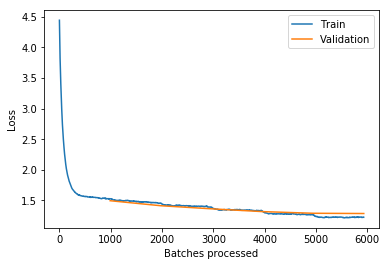

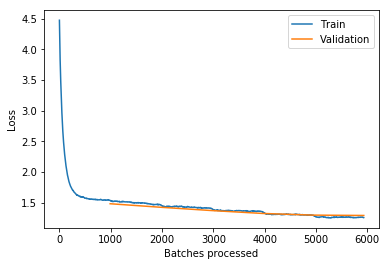

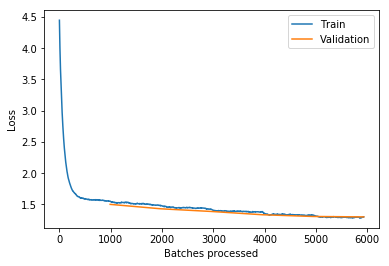

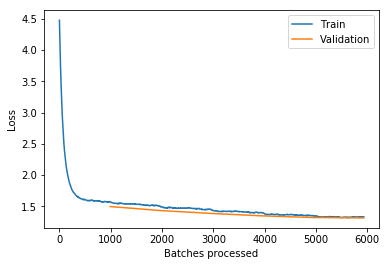

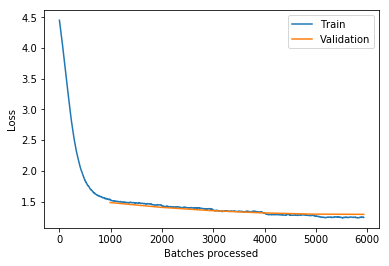

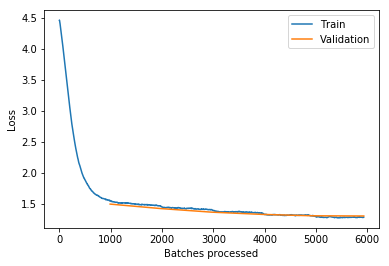

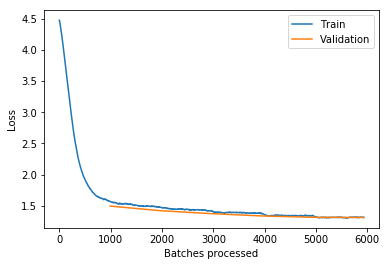

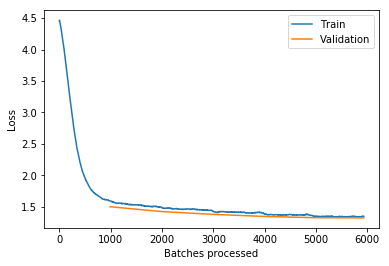

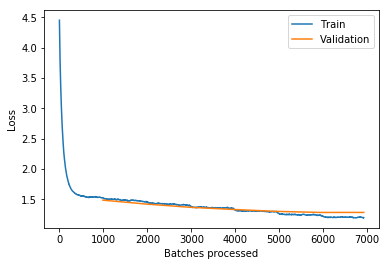

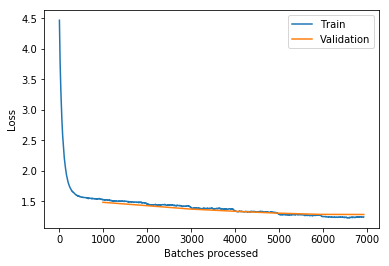

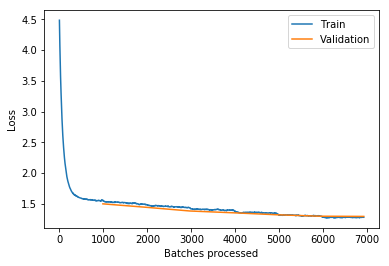

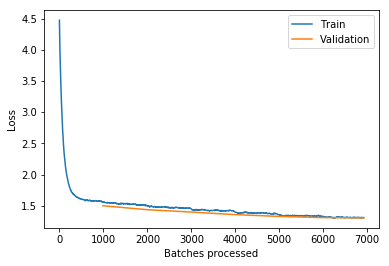

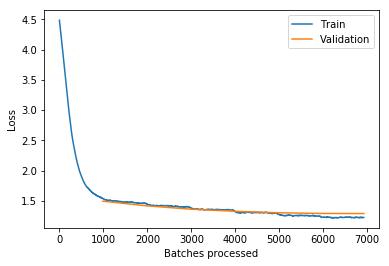

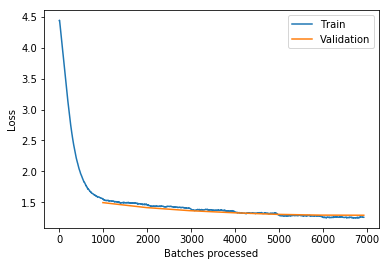

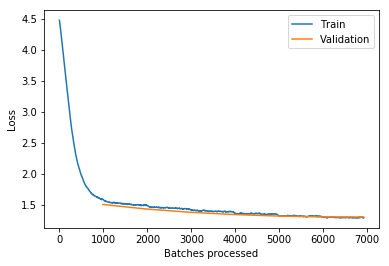

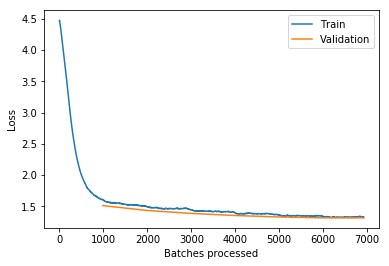

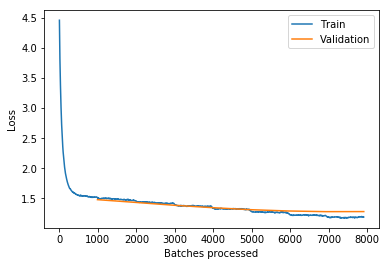

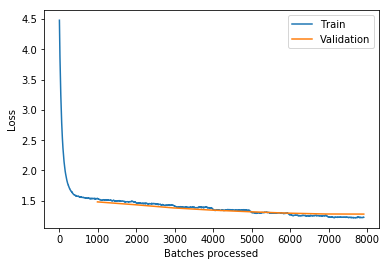

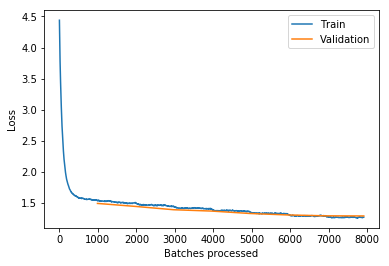

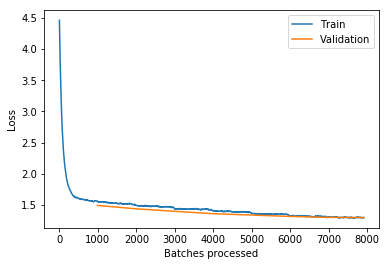

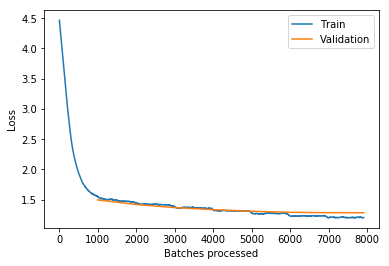

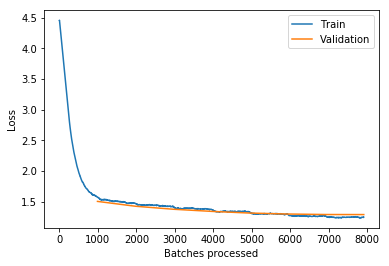

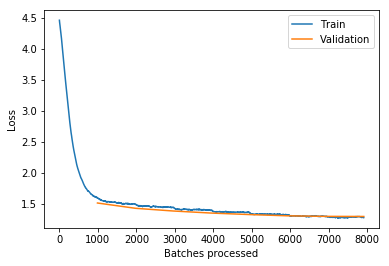

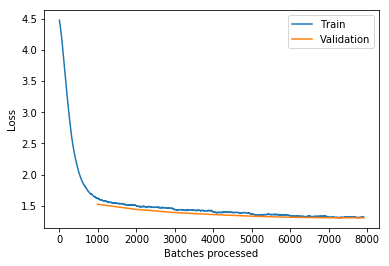

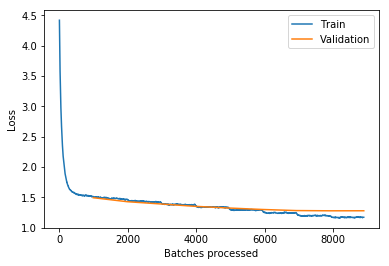

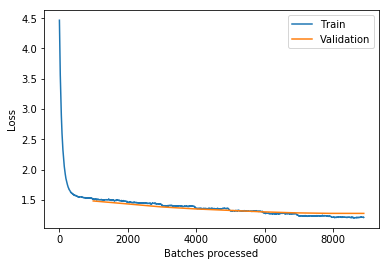

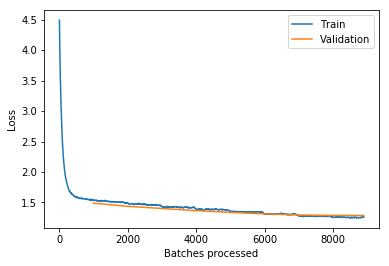

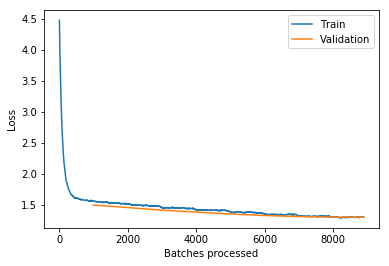

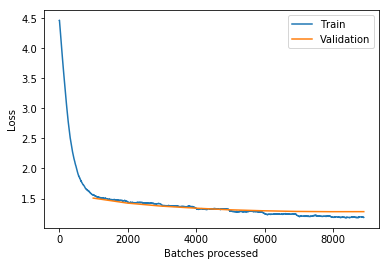

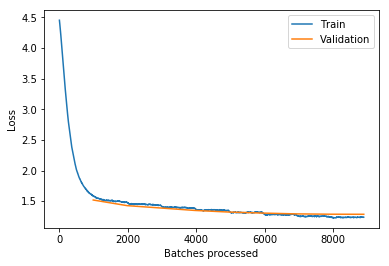

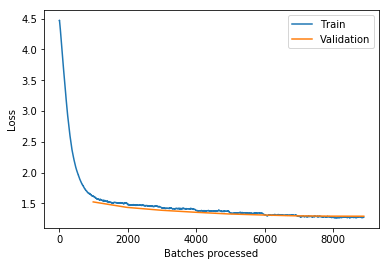

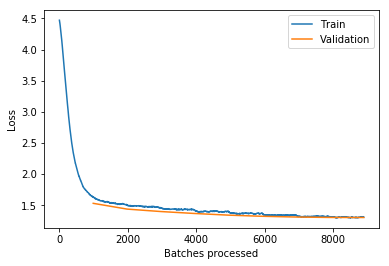

In [64]:
for epochs in np.arange(5,9)+1:
    for lr in [1e-2, 1e-3]:
        for p in np.arange(3, 7)*5/100:
            run_loop(p,lr,epochs)

In [55]:
#p=0.20, lr=1e-3, epochs=30
# learn = tabular_learner(data, layers=[727,353], ps=0.2, emb_drop=0.2, metrics=accuracy)
# learn.load(f'{model_name}-30-{1e-3}-{0.20}-fitted')
# learn.export(f'{model_name}-30-{1e-3}-{0.20}-fitted-export.pkl')